# Statistiques descriptives : la compréhension du corpus de questions

Idée : comprendre la structure du corpus, identifier ses limites

## Préliminaires : importations et définitions utiles pour la suite

On commence par installer les modules pour la compatibilité :

In [ ]:
!pip install geoviews
!pip install geopandas
!pip install --upgrade pip
!pip install --upgrade Pillow
!pip install wordcloud

On importe ensuite ce dont on aura besoin : 

In [2]:
import os

import matplotlib.pyplot as plt
import pandas as pd

import geoviews
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import Counter

import wordcloud
from wordcloud import WordCloud
import numpy as np
import io
import requests
import PIL
import matplotlib.pyplot as plt
import random

On définit ensuite le set de couleur qui sera utilisé dans les graphes suivants, en particulier pour la lisibilité des groupes politiques : 

In [3]:
dict_couleurs = {'Libertés, Indépendants, Outre-mer et Territoires': 'grey',
         'Les Républicains': 'blue',
         'Démocrate (MoDem et Indépendants)': 'orange',
         'Renaissance': 'yellow',
         'Gauche démocrate et républicaine - NUPES': 'red',
         'La France insoumise - Nouvelle Union Populaire écologique et sociale': 'purple',
         'Rassemblement National': 'black',
         'Horizons et apparentés': 'lightblue',
         'Écologiste - NUPES': 'green',
         'Socialistes et apparentés': 'pink',
         'Non inscrit': 'grey'}

default_color = 'blue'

Importation de la donnée nécessaire pour la suite :

In [4]:
# Current directory
current_dir = os.path.dirname('Statistiques descriptives')  

# Relative path to the target file
relative_path = os.path.join('..', 'Datascrapping', 'data_cleaned.csv')

# Absolute path to the target file
absolute_path = os.path.abspath(os.path.join(current_dir, relative_path))

In [5]:
# Charger le fichier CSV dans un DataFrame
df_questions = pd.read_csv(absolute_path, encoding='utf-8', sep='|')

# Afficher les premières lignes du DataFrame
df_questions.tail()


,id,groupe,nom,ministère_interrogé,rubrique,titre,date,question,question_clean
14242,14243,Rassemblement National,Mme Mathilde Paris,Transports,transports ferroviaires,Inégalités dans l'accès aux services ferroviai...,02/01/2024,Mme Mathilde Paris appelle l'attention de M. l...,appeler déléguer auprès transition écologique ...
14243,14244,Socialistes et apparentés,Mme Claudia Rouaux,Mer,transports par eau,Décrets d'application de la loi n°2023-659 du ...,02/01/2024,Mme Claudia Rouaux appelle l'attention de M. l...,appeler secrétaire état auprès charger mer loi...
14244,14245,Gauche démocrate et républicaine - NUPES,M. Yannick Monnet,"Travail, plein emploi et insertion",travail,Lutter contre les accidents du travail par la ...,02/01/2024,M. Yannick Monnet interroge M. le ministre du ...,interroger travail plein emploi insertion néce...
14245,14246,Démocrate (MoDem et Indépendants),M. Pascal Lecamp,"Travail, plein emploi et insertion",travail,Précision des conditions de recours aux contra...,02/01/2024,M. Pascal Lecamp appelle l'attention de M. le ...,appeler travail plein emploi insertion modalit...
14246,14247,Les Républicains,Mme Justine Gruet,Justice,travail,Simplification de la procédure dans la lutte c...,02/01/2024,Mme Justine Gruet appelle l'attention de M. le...,appeler garde sceau justice efficience procédu...


Importation de la correspondance député-département : 

In [6]:
# Relative path to the target file
relative_path = os.path.join('..', 'Datascrapping', 'Scrapping_departements_deputes.ipynb')

# Absolute path to the target file
absolute_path = os.path.abspath(os.path.join(current_dir, relative_path))


In [32]:
%run -i {absolute_path} --no-import-all

departement_mp = fonction_depute_par_departement()

## Introduction : des fonctions de bases pour la représentation graphique 

Première fonction : tracé d'histogramme à partir d'un dictionnaire, avec une colorisation correcte si les clés sont des groupes politiques :

In [8]:
def plot_top_n_keys(dictionary, n, x, y, title): # fonction unique qui sera utilisée par la suite : gestion de cas pour les couleurs
    sorted_items = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)

    top_n_items = sorted_items[:n]

    keys, values = zip(*top_n_items)

    # Define a default color for categories not in the dictionary
    default_color = 'blue'

    # Create the barplot using the defined colors
    colors = [dict_couleurs.get(cat, default_color) for cat in keys]

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(keys, values, color=colors)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

Deuxième fonction : tracé d'une carte avec des valeurs par département à partir d'un dictionnaire

In [9]:
def trace_carte(dico_dep,title):
    # On charge une carte des départements
    url = "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb" 
    geo = gpd.read_file(url)

    # Merge the GeoDataFrame with the values from the dictionary
    gdf = geo.merge(pd.DataFrame(list(dico_dep.items()), columns=['nom', 'value']), how='left', on='nom')

    gdf['value'].fillna(0, inplace=True)
    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(column='value', cmap='GnBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

    # Add a title and legend
    plt.title(title)
    plt.axis("off")
    plt.show()

## Partie I : Répartition des questions par groupe politique

Pour débuter, nous allons nous intéresser à la proportion de questions aux gouvernements écrites en fonction de l'appartenance à un groupe politique




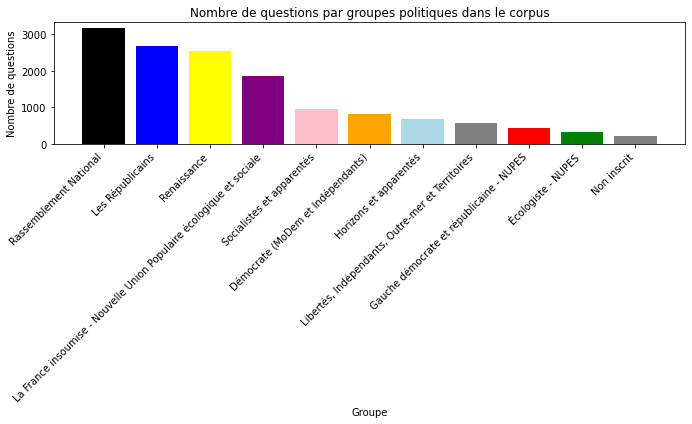

In [10]:
groupes = Counter(df_questions['groupe'].tolist())
plot_top_n_keys(groupes, 30, x="Groupe", y="Nombre de questions", title= f'Nombre de questions par groupes politiques dans le corpus')

## Partie II : Répartition des questions par département d'origine

In [11]:
liste_deputes = df_questions['nom'].tolist()

liste_meme_format = [entry.replace('M. ', '').replace('Mme ', '') for entry in liste_deputes]

mp_numbers = Counter(liste_meme_format)

In [12]:
departement_sums = {}

for departement, mp_list in departement_mp.items():
    sum_for_departement = sum(mp_numbers.get(mp, 0) for mp in mp_list)
    departement_sums[departement] = sum_for_departement

print(departement_sums)

{'Ain': 189, 'Isère': 144, 'Seine-Saint-Denis': 290, 'Haute-Corse': 33, 'Seine-Maritime': 150, 'Doubs': 160, 'Marne': 82, 'Aveyron': 26, 'Indre-et-Loire': 55, 'Bouches-du-Rhône': 308, 'Rhône': 182, 'Paris': 184, 'Loire-Atlantique': 150, 'Essonne': 158, 'Français': 89, 'Drôme': 127, 'Charente-Maritime': 178, 'Haute-Savoie': 42, 'Haute-Garonne': 259, 'Vaucluse': 148, 'Finistère': 92, 'Oise': 141, 'Mayenne': 50, 'Guadeloupe': 42, 'Aude': 148, 'La': 118, 'Loire': 133, 'Deux-Sèvres': 52, 'Meurthe-et-Moselle': 208, 'Aube': 83, 'Aisne': 120, 'Moselle': 207, 'Vendée': 150, 'Vienne': 39, 'Ille-et-Vilaine': 271, 'Haute-Marne': 53, 'Yvelines': 79, 'Nord': 645, 'Gard': 76, 'Pas-de-Calais': 390, "Val-d'Oise": 103, 'Pyrénées-Orientales': 93, 'Calvados': 109, 'Maine-et-Loire': 59, 'Var': 232, 'Savoie': 118, 'Cantal': 18, "Côte-d'Or": 117, "Côtes-d'Armor": 32, 'Territoire': 94, 'Gironde': 168, 'Côtes': 3, 'Hauts-de-Seine': 184, 'Allier': 96, 'Val-de-Marne': 222, 'Hautes-Alpes': 45, 'Loiret': 163, 'Pyr

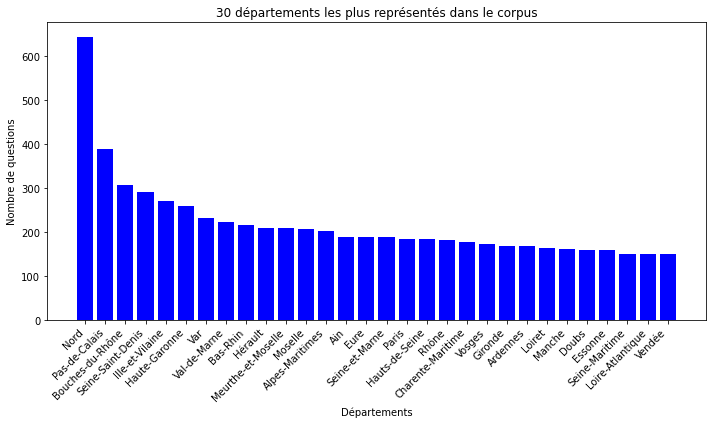

In [13]:
n=30
plot_top_n_keys(departement_sums, n, x="Départements", y="Nombre de questions", title= f'{n} départements les plus représentés dans le corpus')

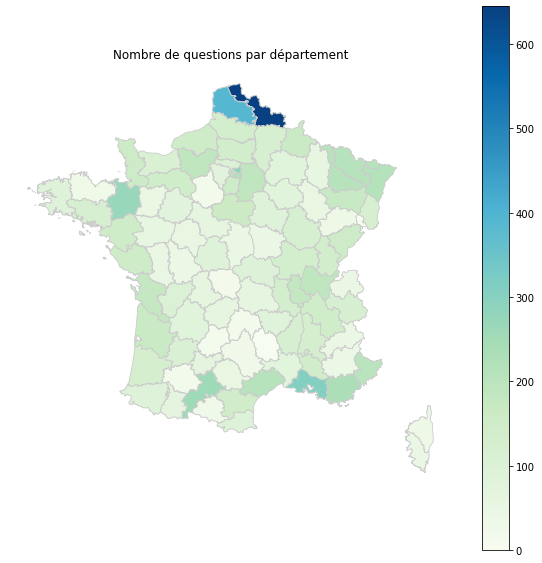

In [14]:
trace_carte(departement_sums,f"Nombre de questions par département")

## Partie III : Répartition des question par thématique : rubrique et ministère

In [15]:
ministere = Counter(df_questions['ministère_interrogé'].tolist())

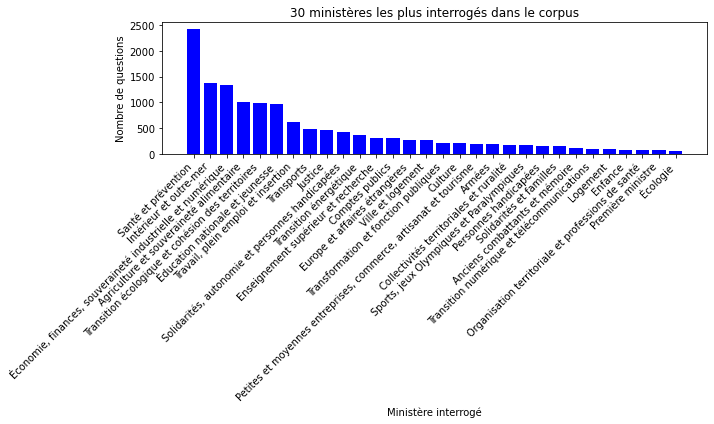

In [16]:
plot_top_n_keys(ministere, 30, x="Ministère interrogé", y="Nombre de questions", title= f'{n} ministères les plus interrogés dans le corpus')

## Partie IV : Etudes du contenu : nuages de mots


In [17]:
questions = " ".join(df_questions["question_clean"])

def clean_text(text):
    text = text.lower() 
    text = " ".join(text.split())
    return text

questions = clean_text(questions)

In [18]:
occurrences = WordCloud().process_text(questions)

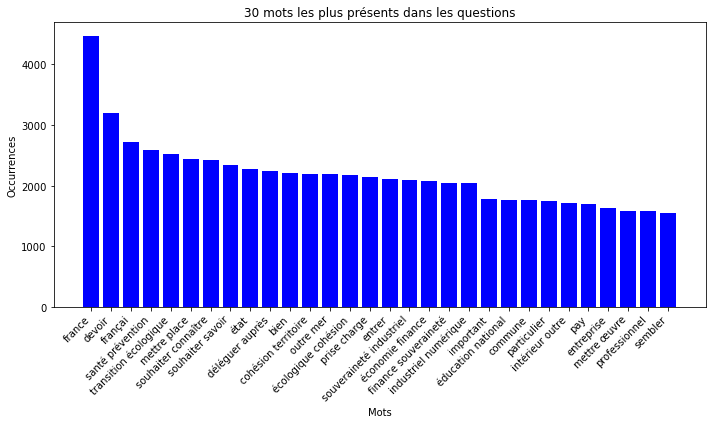

In [19]:
n=30

plot_top_n_keys(occurrences, n, x="Mots", y="Occurrences", title= f'{n} mots les plus présents dans les questions')

(-0.5, 959.5, 865.5, -0.5)

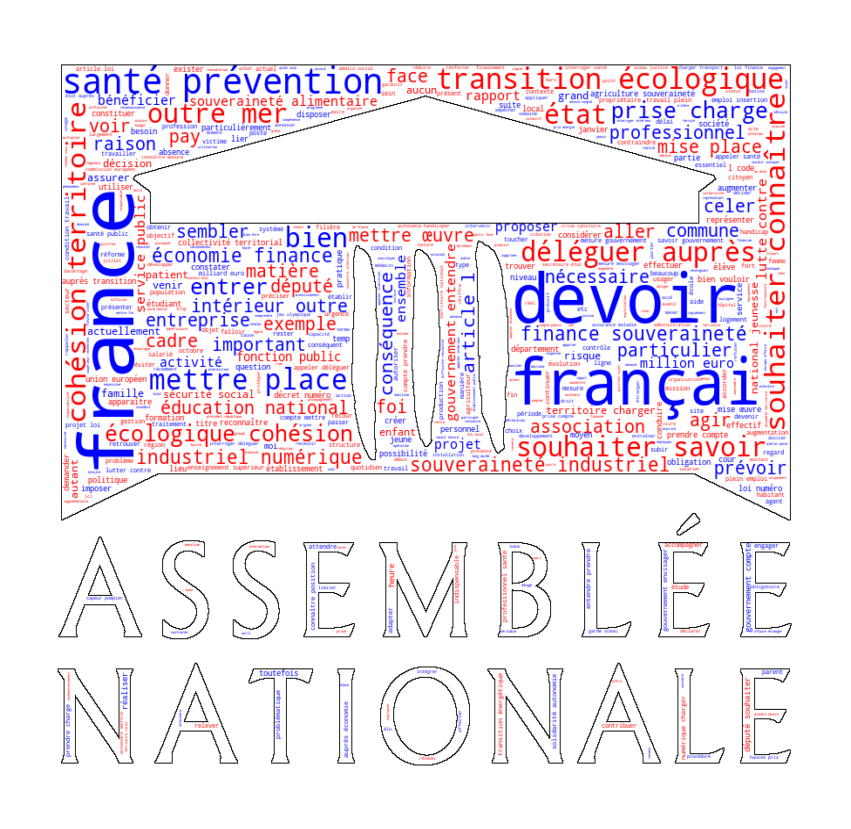

In [20]:
img = "https://upload.wikimedia.org/wikipedia/commons/a/ad/FRNationalAssemblyLogo.png"
an_mask = np.array(PIL.Image.open(io.BytesIO(requests.get(img).content)))

wc = wordcloud.WordCloud(background_color="white", max_words=200000, mask=an_mask, contour_width=0.1, contour_color='black').generate(questions)

def couleur(word, font_size, position, orientation, random_state=None, **kwargs):
    # Randomly choose between red and blue
    color = random.choice(['red', 'blue'])
    return color

plt.figure(figsize=(15, 15))
plt.imshow(wc.recolor(color_func=couleur), interpolation='bilinear', aspect='auto')
plt.axis("off")

## Partie V : Quelques mots discriminants : qui prononce quoi ? 

In [21]:
occurrences.get("violence")

125

In [22]:
def qui_prononce_quoi(target_words):
    filtered_rows = df_questions[df_questions['question_clean'].str.contains('|'.join(target_words))]
    selection_lignes = filtered_rows['groupe'].tolist()
    dico_prononce = Counter(selection_lignes)

    #On adapte le titre
    if len(target_words) == 1:
        title = f"Utilisation du mot {target_words[0]} par groupe politique"
    else:
        title = f"Utilisation des mots \n {', '.join(target_words[:-1])} et {target_words[-1]} par groupe politique"


    plot_top_n_keys(dico_prononce, n=30, x="Groupe", y="Occurrences", title = title)

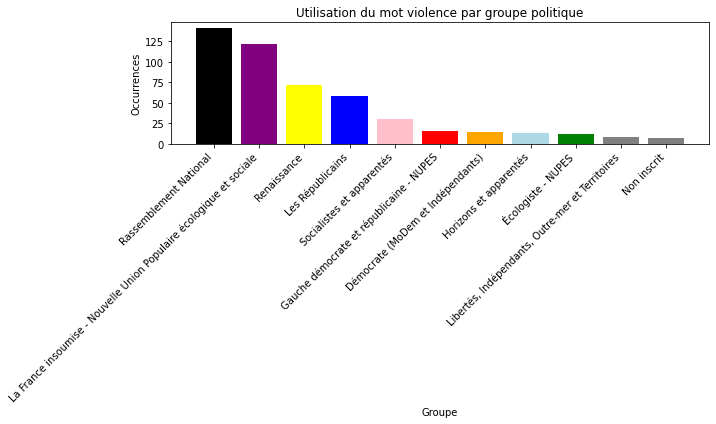

In [23]:
qui_prononce_quoi(['violence'])

Problème : surreprésentation de ceux qui posent le plus de question... 

On peut essayer de normaliser par le nombre de question posé par le groupe ! 

In [24]:
def qui_prononce_quoi_normalise(target_words):
    filtered_rows = df_questions[df_questions['question_clean'].str.contains('|'.join(target_words))]
    selection_lignes = filtered_rows['groupe'].tolist()
    dico_prononce = Counter(selection_lignes)
    questions_par_groupe = Counter(df_questions['groupe'].tolist())

    dico_prononce_normalise = Counter({key : dico_prononce[key] / questions_par_groupe[key] for key in questions_par_groupe})

    #On adapte le titre
    if len(target_words) == 1:
        title = f"Utilisation du mot {target_words[0]} par groupe politique (normalisé)"
    else:
        # Join multiple words with a comma and an 'et' before the last word
        title = f"Utilisation des mots \n {', '.join(target_words[:-1])} et {target_words[-1]} par groupe politique \n (normalisé)"


    plot_top_n_keys(dico_prononce_normalise, n=30, x="Groupe", y="Occurrences normalisées par le nombre de questions du groupe", title = title)

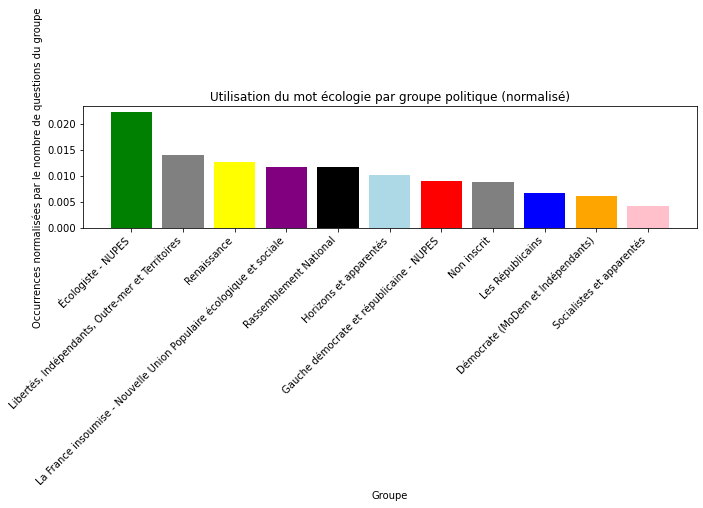

In [25]:
qui_prononce_quoi_normalise(['écologie'])

In [26]:
def qui_prononce_quoi_camembert(target_words):
    filtered_rows = df_questions[df_questions['question_clean'].str.contains('|'.join(target_words))]
    selection_lignes = filtered_rows['groupe'].tolist()
    dico_prononce = Counter(selection_lignes)

    dico_prononce = Counter(selection_lignes)
    questions_par_groupe = Counter(df_questions['groupe'].tolist())
    nb_questions = len(df_questions['groupe'].tolist())

    dico_prononce_normalise = Counter({key : dico_prononce[key] / questions_par_groupe[key] for key in questions_par_groupe})

    #pour avoir un affichage plus comode en enlevant les catégories non significatives
    dico_prononce_normalise_filtre = {cat: val for cat, val in dico_prononce_normalise.items() if val >= 1/nb_questions}

    categories = list(dico_prononce_normalise_filtre.keys())
    values = list(dico_prononce_normalise_filtre.values())

    colors = [dict_couleurs.get(cat, 'blue') for cat in categories]

    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.axes(aspect='equal')  

    plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=90, colors=colors)

    #White center pour la lisibilité
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    #On adapte le titre
    if len(target_words) == 1:
        title = f"Diagramme circulaire de l'usage du mot {target_words[0]} par les groupes politiques"
    else:
        # Join multiple words with a comma and an 'et' before the last word
        title = f"Diagramme circulaire de l'usage des mots \n {', '.join(target_words[:-1])} et {target_words[-1]} par les groupes politiques"


    plt.title(title)

    # Show the plot
    plt.show()

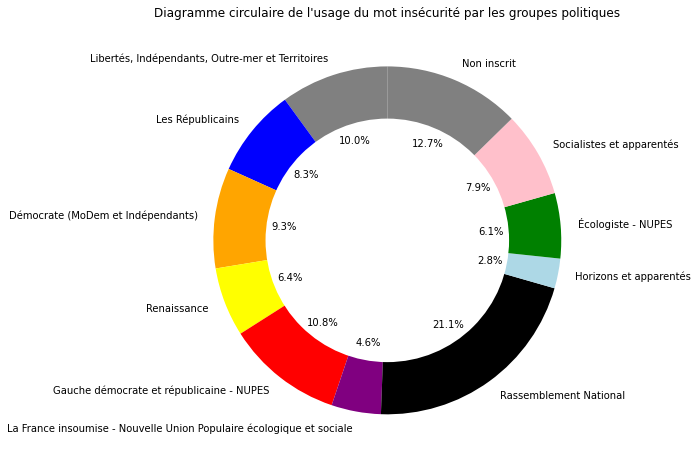

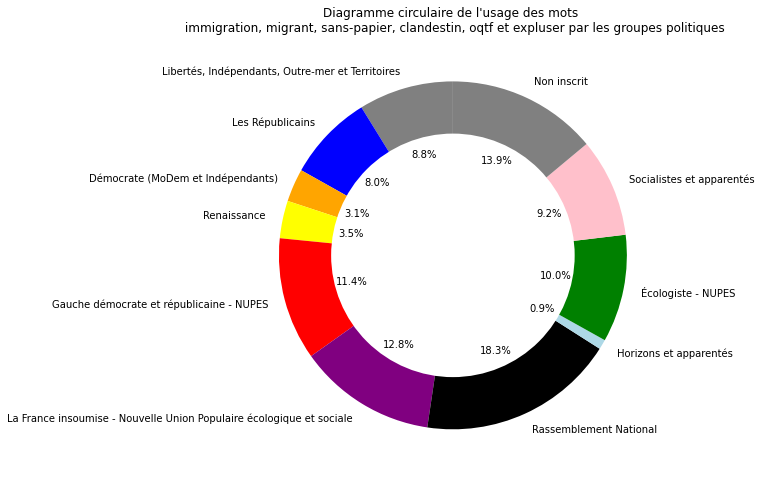

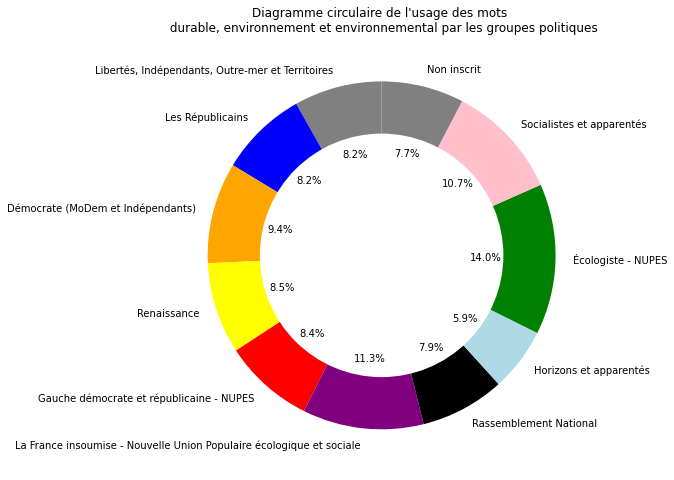

In [27]:
qui_prononce_quoi_camembert(['insécurité'])
qui_prononce_quoi_camembert(['immigration','migrant','sans-papier','clandestin','oqtf','expluser'])
qui_prononce_quoi_camembert(['durable','environnement','environnemental'])

On peut aussi regarder de quel département sont élus les députés qui prononcent ces mots :

In [28]:
def localisation_mot(target_words):

    #on récupère la somme des questions par département (incluant ce mot)
    filtered_rows = df_questions[df_questions['question_clean'].str.contains('|'.join(target_words))]
    selection_deputes = filtered_rows['nom'].tolist()
    liste_meme_format = [entry.replace('M. ', '').replace('Mme ', '') for entry in selection_deputes]

    mp_numbers = Counter(liste_meme_format)

    departement_partial_sums = {}

    for departement, mp_list in departement_mp.items():
        sum_for_departement = sum(mp_numbers.get(mp, 0) for mp in mp_list)
        departement_partial_sums[departement] = sum_for_departement

    #on récupère la somme des questions par département pour avoir des facteurs de normalisation

    departement_sums = {}

    deputes = df_questions['nom'].tolist()
    liste_meme_format = [entry.replace('M. ', '').replace('Mme ', '') for entry in deputes]

    all_mp_numbers = Counter(liste_meme_format)

    for departement, mp_list in departement_mp.items():
        sum_for_departement = sum(all_mp_numbers.get(mp, 0) for mp in mp_list)
        departement_sums[departement] = sum_for_departement


    #on normalise le premier dictionnaire par le second
    dico_normalise = Counter({key: departement_partial_sums[key] / departement_sums[key] if departement_sums[key] != 0 else 0 for key in departement_sums})
    
    #On adapte le titre
    if len(target_words) == 1:
        title = f"D'où sont issus les députés qui prononcent le mot {target_words[0]} ?"
    else:
        # Join multiple words with a comma and an 'et' before the last word
        title = f"D'où sont issus les députés qui prononcent les mots \n {', '.join(target_words[:-1])} et {target_words[-1]} ?"


    plot_top_n_keys(dico_normalise, n=30, x="Département", y="Occurrences", title = title)
    trace_carte(dico_normalise,title)

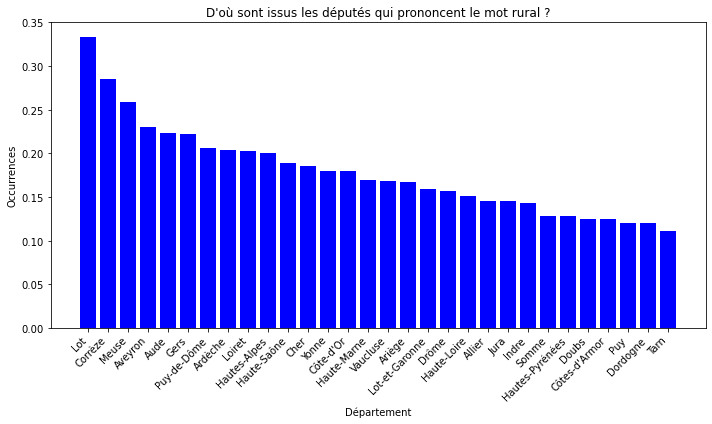

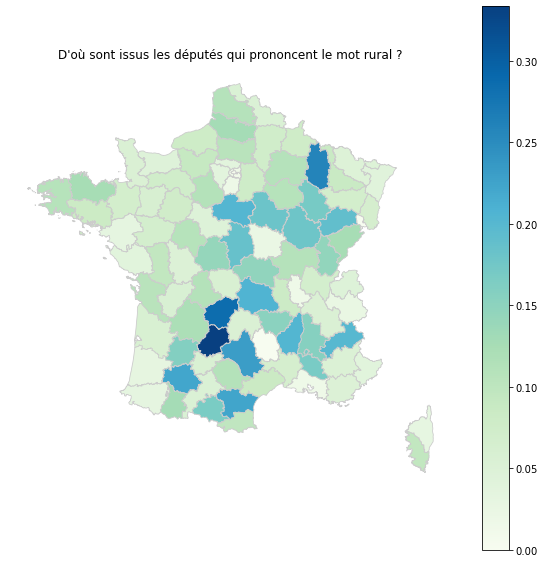

In [29]:
target_words = ["rural"]

localisation_mot(target_words)

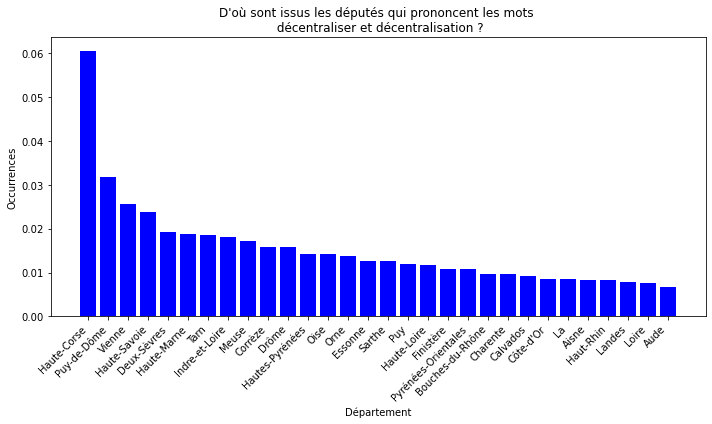

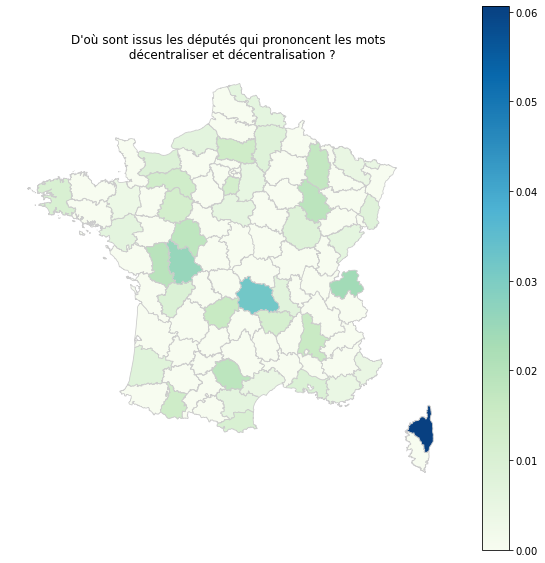

In [30]:
target_words = ["décentraliser","décentralisation"]

localisation_mot(target_words)